### 티처블머신 (이미지에서 남/여 구분)



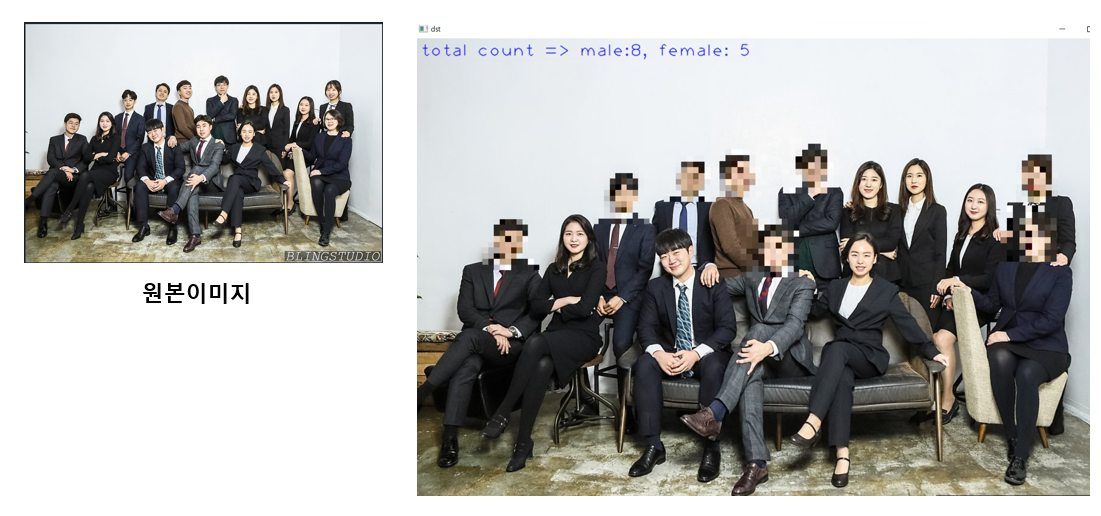



## 코드 정리

In [25]:
from keras.models import load_model
from PIL import Image, ImageOps
import numpy as np
import matplotlib.pyplot as plt
import cv2
import pandas as pd
# Disable scientific notation for clarity
np.set_printoptions(suppress=True)

# Load the model
model = load_model("./converted_keras/keras_Model.h5", compile=False)

# Load the labels
class_names = open("./converted_keras/labels.txt", "r").readlines()

# 성별구분(gender) 함수 정의
def gender(imgArea):
    # Create the array of the right shape to feed into the keras model
    # The 'length' or number of images you can put into the array is
    # determined by the first position in the shape tuple, in this case 1
    data = np.ndarray(shape=(1, 224, 224, 3), dtype=np.float32)

    # Replace this with the path to your image
    image = Image.open(imgArea).convert("RGB")

    # resizing the image to be at least 224x224 and then cropping from the center
    size = (224, 224)
    image = ImageOps.fit(image, size, Image.Resampling.LANCZOS)

    # turn the image into a numpy array
    image_array = np.asarray(image)

    # Normalize the image
    normalized_image_array = (image_array.astype(np.float32) / 127.5) - 1

    # Load the image into the array
    data[0] = normalized_image_array

    # Predicts the model
    prediction = model.predict(data)
    index = np.argmax(prediction)
    class_name = class_names[index]
    confidence_score = prediction[0][index]

    
    return class_name[2:].strip(),confidence_score

#-----------------------------------------
# 모자이크 처리함수
# ------------------------------------------
def mosaic(src, ratio=0.1):
    small = cv2.resize(src, None, fx=ratio, fy=ratio, interpolation=cv2.INTER_NEAREST)
    return cv2.resize(small, (src.shape[1],src.shape[0]), interpolation=cv2.INTER_NEAREST)

#-----------------------------------------------------------------------
#오픈CV로 쉽게 얼굴 인식하고 성별 구분 함수 적용
#----------------------------------------------------------------------
import cv2

# haarcascade 불러오기
face_cascade = cv2.CascadeClassifier(cv2.data.haarcascades + 'haarcascade_frontalface_default.xml')

# 이미지 불러오기
img = cv2.imread('open_cv_1.jpg')
gray = cv2.cvtColor(img, cv2.COLOR_BGR2GRAY)

# 얼굴 찾기
faces = face_cascade.detectMultiScale(gray,1.2,5)

# for x, y, w, h in faces:
#     cv2.rectangle(img, (x-20, y-20, w+40, h+40), (255, 0, 0), 2)
# cv2.imshow('img',img)
# cv2.waitKey(0)
# cv2.destroyAllWindows()

predict=[]
#print(faces)
cnt=0
for (x, y, w, h) in faces:

    cv2.rectangle(img, (x-20, y-20, w+40, y + 40), (255, 0, 0), 2)
    
    roi_color = img[y-20:y + h+20, x-20:x + w+20]
    cv2.imwrite('tmp.jpg',roi_color)
    pre=gender('tmp.jpg')
    
    predict.append(pre)
    
#---------------------------
# 성별 현황집계
#---------------------------
df=pd.DataFrame(predict,columns=['성별','비율'])
tot=df['성별'].value_counts()
#현황 텍스트
txt=f'total count => male:{tot["male"]}, female: {tot["female"]}'

#-------------------------------------------------------------
# 최종 결과 : 이미지에 얼굴 바운딩박스, 예측 텍스트 표시
#----------------------------------------------------------------
img = cv2.imread('open_cv_1.jpg')

# 폰트 색상 지정
blue = (255, 0, 0)
green= (0, 255, 0)
red= (0, 0, 255)
white= (255, 255, 255) 
font =  cv2.FONT_HERSHEY_PLAIN

img = cv2.putText(img, txt, (10, 30), font, 2, blue, 1, cv2.LINE_AA)
dst=img.copy()#원본이미지 백엄
for (x, y, w, h),result in zip(faces,predict):
    if result[0]=='male':
        dst[y-20:y+h+20,x-20:x+ w+20]=mosaic(dst[y-20:y+h+20,x-20:x+ w+20])
cv2.imshow('dst',dst)
cv2.waitKey(0)
cv2.destroyAllWindows()

1/1 [==============================] - 0s 34ms/step
